In [1]:
import gspread
from google.oauth2.service_account import Credentials

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from linkml_runtime.utils.schemaview import SchemaView
import re

import pprint

In [2]:
schema_with_mam_biased_sels_url = "https://raw.githubusercontent.com/microbiomedata/submission-schema/refs/heads/main/src/nmdc_submission_schema/schema/nmdc_submission_schema.yaml"

In [3]:
sels_enum_name = "EnvLocalScaleSoilEnum"

In [4]:
# 1. Replace with the path to your downloaded JSON key file
SERVICE_ACCOUNT_FILE = 'env-context-voting-sheets-29d0d970ca1d.json'  


In [5]:
## soil-env-local-scale-evidence-table
# SPREADSHEET_ID = "1MChOcbjKEQjsAJlZN8oOlyO3TN09spCnIEAlV8kW1bE"

# Consolidated_soil-env-local-scale-evidence-table
SPREADSHEET_ID = "1epul_bXtEOlmIZYNRhngulI3-HaHhe_tU_BPUia5isQ"


In [6]:
# # Replace 'Your Sheet Name' with the actual name of your sheet
# sheet_name = 'soil-env-local-scale-evidence-table'  

sheet_name = 'soil-env-local-scale-evidence-t'  

In [7]:
# Set up credentials
SCOPES = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]


In [8]:
def compare_curie_dicts(input_dict):
  """
  Compares two dictionaries of curies and labels and reports differences 
  and common elements.

  Args:
    input_dict: A dictionary with two keys representing the group labels and 
                 the values being dictionaries of curie: label pairs.

  Returns:
    A dictionary with three keys:
      - 'first_only': A dictionary of curie: label pairs present only in 
                       the first group.
      - 'second_only': A dictionary of curie: label pairs present only in 
                        the second group.
      - 'shared': A dictionary of curie: label pairs present in both groups.
  """

  group1_label, group1_data = list(input_dict.items())[0]
  group2_label, group2_data = list(input_dict.items())[1]

  first_only_curies = set(group1_data.keys()) - set(group2_data.keys())
  second_only_curies = set(group2_data.keys()) - set(group1_data.keys())
  shared_curies = set(group1_data.keys()) & set(group2_data.keys())

  first_only = {curie: group1_data[curie] for curie in first_only_curies}
  second_only = {curie: group2_data[curie] for curie in second_only_curies}
  shared = {curie: group1_data[curie] for curie in shared_curies}

  return {
      f'{group1_label} only': first_only,
      f'{group2_label} only': second_only,
      'shared': shared
  }

In [9]:
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

In [10]:
gc = gspread.authorize(creds)

In [11]:
# Open the spreadsheet
spreadsheet = gc.open_by_key(SPREADSHEET_ID) 

In [12]:
sheet = spreadsheet.worksheet(sheet_name)

In [13]:
# Get data as a list of lists
data = sheet.get_all_values()

In [14]:
# Convert to DataFrame
df = pd.DataFrame(data[1:], columns=data[0]) 

In [15]:
df

,unique_id,label,all_evidence,is_process,is_quality,is_chemical_entity,is_biome,is_aquatic_biome,is_terrestrial_biome,is_environmental_material,...,MLS_vote,MLS_comments,NMW_vote,NMW_comment,SM_vote,SM_comment,Yes = 1 No = -1 Maybe = 0,IAA_score,vote_sum,was_subjected_to_voting
0,CHEBI:24632,hydrocarbon,0.003288752467,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
1,CHEBI:24866,salt,0.0001096250822,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
2,CHEBI:25555,nitrogen atom,0.0006577504933,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
3,CHEBI:26833,sulfur atom,0.0001096250822,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
4,CHEBI:33287,fertilizer,0.03672440254,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,-1,,,,,,-3,0.4,-3,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,ENVO:00000567,calanque,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1225,ENVO:03500004,bike path,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1226,ENVO:03501248,overpass,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1227,ENVO:00000561,military training area,,,,,,,,,...,,,,,,,,0.4,-2,FALSE


In [16]:
df.columns

Index(['unique_id', 'label', 'all_evidence', 'is_process', 'is_quality',
       'is_chemical_entity', 'is_biome', 'is_aquatic_biome',
       'is_terrestrial_biome', 'is_environmental_material', 'is_soil',
       'is_enriched_soil', 'obsolete', 'non_host_oak_queries_count',
       'historical_permissible_values_count', 'NMDC_soil_count',
       'NCBI_mims_soil_trusting_CURIe_count',
       'NCBI_mims_soil_trusting_labels_count', 'GOLD_env_terr_soil_count',
       'non_host_oak_queries_frequency',
       'historical_permissible_values_frequency', 'NMDC_soil_frequency',
       'NCBI_mims_soil_trusting_CURIe_frequency',
       'NCBI_mims_soil_trusting_labels_frequency',
       'GOLD_env_terr_soil_frequency', 'CJM_Vote', 'CJM_Comments', 'MAM vote',
       'MAM comments', 'MLS_vote', 'MLS_comments', 'NMW_vote', 'NMW_comment',
       'SM_vote', 'SM_comment', 'Yes = 1 No = -1 Maybe = 0', 'IAA_score',
       'vote_sum', 'was_subjected_to_voting'],
      dtype='object')

## Mark's judgement: focus on ABPs and Environmental systems
they're not identified on this sheet

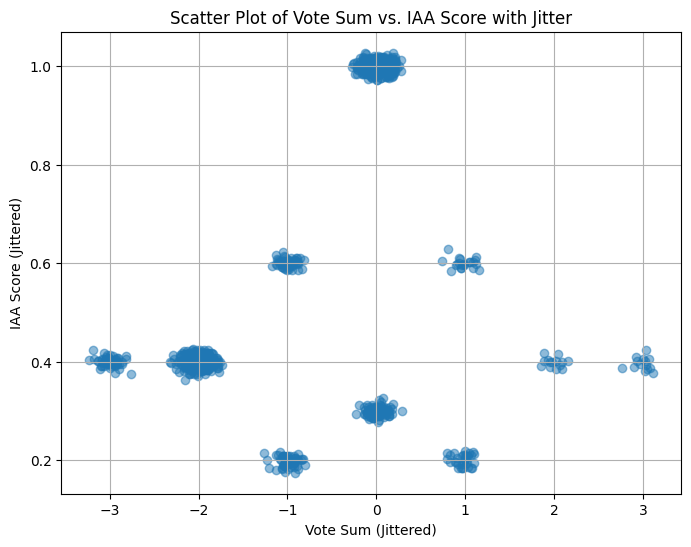

In [17]:
# Convert 'vote_sum' to numeric
df['vote_sum'] = pd.to_numeric(df['vote_sum'], errors='coerce')

# Convert 'IAA_score' to numeric  <--- Add this line
df['IAA_score'] = pd.to_numeric(df['IAA_score'], errors='coerce') 

# Add jitter to 'vote_sum' and 'IAA_score'
df['vote_sum_jittered'] = df['vote_sum'] + np.random.normal(0, 0.1, size=len(df))
df['IAA_score_jittered'] = df['IAA_score'] + np.random.normal(0, 0.01, size=len(df))


# Scatter plot with jittered values
plt.figure(figsize=(8, 6))
plt.scatter(df['vote_sum_jittered'], df['IAA_score_jittered'], alpha=0.5)
plt.xlabel('Vote Sum (Jittered)')
plt.ylabel('IAA Score (Jittered)')
plt.title('Scatter Plot of Vote Sum vs. IAA Score with Jitter')
plt.grid(True)
plt.show()

In [18]:
# Group by 'vote_sum' and 'IAA_score' and count the occurrences
count_table = df.groupby(['vote_sum', 'IAA_score']).size().reset_index(name='count')

In [19]:
count_table

,vote_sum,IAA_score,count
0,-3,0.4,56
1,-2,0.4,404
2,-1,0.2,54
3,-1,0.6,51
4,0,0.3,72
5,0,1.0,509
6,1,0.2,34
7,1,0.6,21
8,2,0.4,14
9,3,0.4,14


In [20]:
# Set your thresholds
vote_sum_threshold = 1  # Example threshold
IAA_score_threshold = 0.0  # Example threshold

In [21]:
# Create the derived DataFrame
vote_filtered_df = df[(df['vote_sum'] >= vote_sum_threshold) & (df['IAA_score'] >= IAA_score_threshold)]

In [22]:
vote_filtered_df

,unique_id,label,all_evidence,is_process,is_quality,is_chemical_entity,is_biome,is_aquatic_biome,is_terrestrial_biome,is_environmental_material,...,NMW_vote,NMW_comment,SM_vote,SM_comment,Yes = 1 No = -1 Maybe = 0,IAA_score,vote_sum,was_subjected_to_voting,vote_sum_jittered,IAA_score_jittered
18,ENVO:00000011,garden,0.1188080752,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.2,1,,0.884572,0.195984
20,ENVO:00000014,canal,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.897693,0.597009
24,ENVO:00000020,lake,0.02299603202,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.937753,0.609188
26,ENVO:00000022,river,0.0144452756,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,3,0.4,3,,3.114522,0.376840
27,ENVO:00000023,stream,0.008964021492,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,2,0.4,2,,2.151598,0.402047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,ENVO:01001568,frost heave,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.991914,0.596716
1072,ENVO:01001803,tropical forest,0.04140378549,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.2,1,,0.955492,0.183542
1115,ENVO:03000117,channel,0.01770879282,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,2,0.4,2,,2.084575,0.399855
1119,ENVO:03500005,anthropogenic litter,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.805134,0.628502


In [23]:
schema_with_mam_biased_sels_url = SchemaView(schema_with_mam_biased_sels_url)

In [24]:
mam_biased_sels_enum = schema_with_mam_biased_sels_url.get_enum(sels_enum_name)

In [25]:
mam_biased_sels_enum_pvs = list(mam_biased_sels_enum.permissible_values.keys())

In [26]:
mam_biased_curie_label_dict = {}
for label_with_curie in mam_biased_sels_enum_pvs:
    match = re.search(r'(.*?) \[(.*?)\]', label_with_curie)  # Extract label and curie
    if match:
        label = match.group(1)
        curie = match.group(2)
        mam_biased_curie_label_dict[curie] = label


In [27]:
# Create the curie dictionary from filtered_df
votes_only_dict = dict(zip(vote_filtered_df['unique_id'], vote_filtered_df['label']))

In [28]:
input_data = {'MAM biased': mam_biased_curie_label_dict, 'Votes': votes_only_dict}

In [29]:
pvs_analysis = compare_curie_dicts(input_data)

In [30]:
pprint.pprint(pvs_analysis)

{'MAM biased only': {'ENVO:00000064': 'road',
                     'ENVO:00000074': 'dam',
                     'ENVO:00000100': 'valley',
                     'ENVO:00000108': 'meadow ecosystem',
                     'ENVO:00000127': 'badland',
                     'ENVO:00000169': 'canyon',
                     'ENVO:00000177': 'moraine',
                     'ENVO:00000181': 'nunatak',
                     'ENVO:00000276': 'drumlin',
                     'ENVO:00000277': 'dry lake',
                     'ENVO:00000280': 'escarpment',
                     'ENVO:00000282': 'esker',
                     'ENVO:00000300': 'scrubland area',
                     'ENVO:00000304': 'shore',
                     'ENVO:00000320': 'crevasse',
                     'ENVO:00000325': 'polje',
                     'ENVO:00000370': 'tuya',
                     'ENVO:00000410': 'kipuka',
                     'ENVO:00000417': 'machair',
                     'ENVO:00000418': 'ria',
                     '